In [195]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import glob


创建dataser





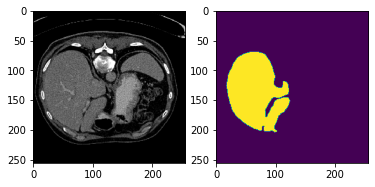

In [214]:
for i, m in dataset_train.take(1):
    plt.subplot(1,2,1)
    plt.imshow((i.numpy()+1)/2)
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(m.numpy()))
    plt.imshow(m.numpy())


In [215]:
dataset_train = dataset_train.cache().repeat().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(auto)
dataset_test = dataset_test.cache().batch(BATCH_SIZE)

In [216]:
dataset_train

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.int32)>

In [217]:
dataset_test

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.int32)>

u-net模型

In [218]:
tf.keras.layers.Layer.call


In [220]:

        
    def call(self,x):
        x1 = self.down_sample_I(x,is_pool=False)
        x2 = self.down_sample_II(x1)
        x3 = self.down_sample_III(x2)
        x4 = self.down_sample_IV(x3)
        x5 = self.down_sample_V(x4)
        
        x5 = self.up_sample(x5)
        
        x5 = tf.concat([x4,x5])
        x5 = self.up_sample_I(x5)
        
        x5 = tf.concat([x3,x5])
        x5 = self.up_sample_II(x5)
        
        x5 = tf.concat([x2,x5])
        x5 = self.up_sample_III(x5)
        
        x5 = tf.concat([x1,x5])
        
        x5 = self.conv_last(x5,is_pool=False)
        
        x5 = self.last(x5)
        return x5

In [221]:
model = myU_net_model()

In [222]:
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __call__(self,y_ture,y_pred,sample_weight=None):
        y_pred = tf.argmax(y_pred,axis=-1)
        return super().__call__(y_ture,y_pred,sample_weight=sample_weight)

训练

In [223]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [224]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_acc')
train_iou = MeanIoU(2,name='tain_iou')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_acc')
test_iou = MeanIoU(2,name='test_iou')

In [225]:
@tf.function
def train_step(images,labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss(labels,predictions)
    gradients = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels,predictions)
    train_iou(labels,predictions)

In [226]:
@tf.function
def test_step(images,labels):
    predictions= model(images)
    t_loss=loss_object(labels,predictions)
    test_loss(t_loss)
    
    test_accuracy(labels,predictions)
    test_iou(labels,predictions)  

In [227]:
EPOCHS = 5
for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    train_iou.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    test_iou.reset_states()
    
    for images,labels in dataset_train:
        train_step(images,labels)
        
    for test_images,test_labels in dataset_val:
        train_step(test_images,test_labels)
        
    template ='EPOCH {:.3f}, Loss:{:.3f}, Accuracy: {:.3f},\
               IOU:{:.3f},Test Loss:{:.3f},\
               Test Acurracy:{:.3f},Test IOU:{:.3f}'
    
    print (template.format(epoch+1,
                           train_loss.result(),
                           train_accuracy.result()*100,
                           train_iou.result(),
                           test_loss.result(),
                           test_accuracy.result()*100,
                           test_iou.result()
                         ))

AttributeError: in user code:

    <ipython-input-225-4b748840138c>:4 train_step  *
        predictions = model(images)
    <ipython-input-220-30e7189a9da9>:28 call  *
        x1 = self.down_sample_I(x,is_pool=False)

    AttributeError: 'myU_net_model' object has no attribute 'down_sample_I'


In [ ]:
60*14

In [ ]:
840/(1+0.55)